##INTRODUCTION TO CONNECTIVE MEDIA - ASSIGNMENT 3
#Exploring anchoring theory with the Yelp dataset
 ###by Jing Dai, Alap Parikh
 
 
##Anchoring
In this assignment we looked to explore how consistent users’ ratings of businesses are based on sentiment analysis of review texts, and consequently attempt to predict ratings solely based on the text content. Furthermore, we looked to see if the error in these predictions arose due to an anchoring bias caused by the existent rating of the business. This business rating is the most prominently seen feature associated with a business profile or business page. In addition to these core concepts, we tried to gain general insight into user behavior based on a couple of simple plots.

##Data
We used a Yelp dataset available to us as part of an ongoing Yelp challenge. This dataset, among other things, contained a collection of reviews which contained attributes such as user ID, business ID, rating in stars, text, and date. We performed our analysis using this and the corresponding rating for every business from the collection of businesses. We used a total of 1238 users, and analyzed 60 reviews per user. 

##Report
The results and the analysis are included in the following file:

https://github.com/jingdai2014/introcm_data_analysis/blob/master/ConnectiveMedia-Assignment3.pdf

All the codes and the plots can be found below. 

In [174]:
import json
import numpy as np
from textblob import TextBlob

userdict={}
with open('./yelp/user.json') as user_file:
    for line in user_file:
        d=json.loads(line)
        if (d["review_count"]>150):
            userdict[d["user_id"]] = d["review_count"] 

In [175]:
count={}
with open('./yelp/review.json') as review_file:
    for line in review_file:
        d=json.loads(line)        
        if (d["user_id"] in count):
            count[d["user_id"]]+=1
        else:
            count[d["user_id"]]=1

userlist=[]
for key in count:
    if (count[key]>100):
        userlist.append(key)
print len(userlist)

1238


In [176]:
businessdict = {}
with open('./yelp/business.json') as business_file:
    for line in business_file:
        d=json.loads(line)
        businessdict[d["business_id"]] = d["stars"]

In [177]:
master_review={}
with open('./yelp/review.json') as review_file:
    for line in review_file:
        d=json.loads(line)
        if (d["user_id"] in userlist):
            if (d["user_id"] not in master_review):
                master_review[d["user_id"]] = {}
            
            key=int(d["date"].replace("-","")+"00")
            while (key in master_review[d["user_id"]]):
                key+=1
            
            ls = [d["business_id"], d["stars"], d["text"]]
            master_review[d["user_id"]][key]=ls

In [178]:
import random
diff_n_stars=[]
diff_pred=[]
actual_pred=[]
ba_pred=[]
rates=[]
avg_diff=[]

diff_sentiments=[]
for uid in userlist:
    #uid = userlist[4]
    reviewdict=master_review[uid]
    dates = sorted(reviewdict, key=reviewdict.get)
    n_stars=[]
    overall_stars=[]
    n_sentiments=[]
    for i in range(30):
        n_stars.append(reviewdict[dates[i]][1])
        review_text = reviewdict[dates[i]][2]
        blob = TextBlob(review_text)
        n_sentiments.append(blob.sentiment.polarity)
        
    for d in dates:
        overall_stars.append(reviewdict[d][1])
        
    diff_n_stars.append(abs(np.mean(n_stars)-np.mean(overall_stars)))
    
    #normalize sentiments
    
    diff_sentiments.append((np.mean(n_sentiments)+1)/2.0-(np.mean(n_stars)-1)/4.0)
    
    
    # choose random 30 dates
    dates2 = dates[30:]
    random.shuffle(dates2)
    dates2 = dates2[:30]

    #get the sentiment of the current review and the rate
    actual_stars=[]
    pred_sentiments=[]
    business_stars=[]
    for date in dates2:
        business_stars.append(businessdict[reviewdict[date][0]])
        actual_stars.append(reviewdict[date][1])
        pred_text = reviewdict[date][2]
        blob = TextBlob(pred_text)
        pred_sentiments.append(blob.sentiment.polarity)
    
    
    #calculate the predicted rating based on users average sentiment
    pred_stars=[]
    avg_stars=np.mean(n_stars)
    avg_sentiments = np.mean(n_sentiments)
    # absolute differnece between predicted ratings and the actual ratings
    diff1=[]
    for i in range(30):
        pred=(pred_sentiments[i]-avg_sentiments)/2*4+avg_stars
        pred=min(5, pred)
        pred=max(1, pred)
        pred_stars.append(pred)
        diff1.append(abs(pred-actual_stars[i]))
        diff_pred.append(abs(pred-actual_stars[i]))
    avg_diff.append(np.mean(diff1))
    
    count=0
    for i in range(30):
        actual_pred.append(actual_stars[i]-pred_stars[i])
        ba_pred.append(business_stars[i]-pred_stars[i])
        if (business_stars[i]-pred_stars[i])*(actual_stars[i]-pred_stars[i])>0:
            count+=1 
        
    rates.append(count/30.0)


print np.mean(diff_n_stars)
print np.mean(diff_pred)
print np.mean(rates) 

0.13875283688
0.757941708188
0.629402261712


Counts: [ 206.  186.  191.  159.  119.  105.   83.   64.   38.   25.   21.   17.
    4.    7.    2.    4.    4.    2.    0.    1.]
Bins, [ 0.          0.03536232  0.07072464  0.10608696  0.14144928  0.17681159
  0.21217391  0.24753623  0.28289855  0.31826087  0.35362319  0.38898551
  0.42434783  0.45971014  0.49507246  0.53043478  0.5657971   0.60115942
  0.63652174  0.67188406  0.70724638]


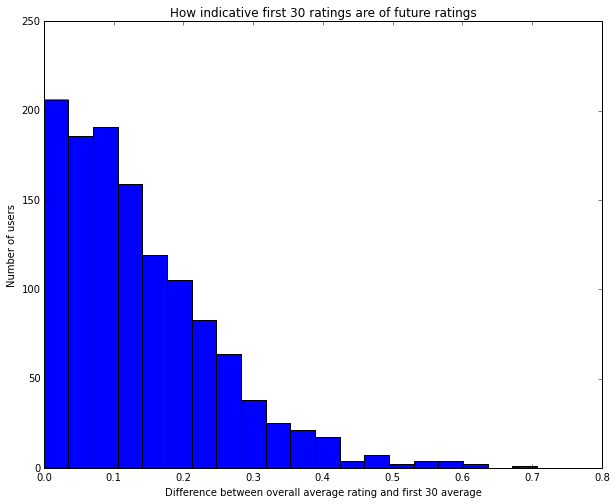

In [179]:
%matplotlib inline
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(1,1,1)
n, bins, patches=ax.hist(diff_n_stars, bins=20)
ax.set_xlabel("Difference between overall average rating and first 30 average")
ax.set_ylabel("Number of users")
ax.set_title("How indicative first 30 ratings are of future ratings")
print "Counts:", n
print "Bins,", bins

In [180]:
print (n[0]+n[1]+n[2])/sum(n)

0.470920840065


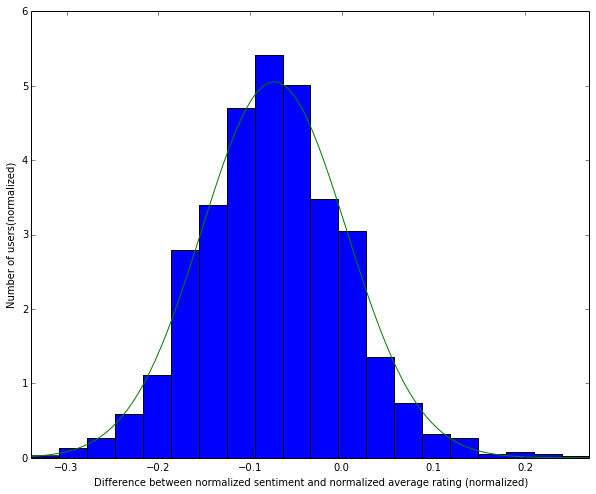

Offset:  -0.0735775366453


In [181]:
plt.figure(1,figsize=(10,8))
result = plt.hist(diff_sentiments, normed=True, bins=20)
plt.xlim((min(diff_sentiments), max(diff_sentiments)))

mean = np.mean(diff_sentiments)
variance = np.var(diff_sentiments)
sigma = np.sqrt(variance)
x = np.linspace(min(diff_sentiments), max(diff_sentiments),100)
plt.plot(x, mlab.normpdf(x,mean,sigma))
plt.xlabel("Difference between normalized sentiment and normalized average rating (normalized)")
plt.ylabel("Number of users(normalized)")

plt.show()
print "Offset: ", mean

Counts: [  6.01300000e+03   5.65800000e+03   4.96200000e+03   4.38800000e+03
   3.71300000e+03   3.24300000e+03   2.74800000e+03   2.07200000e+03
   1.50100000e+03   9.03000000e+02   6.29000000e+02   4.46000000e+02
   3.16000000e+02   2.27000000e+02   1.70000000e+02   9.30000000e+01
   3.10000000e+01   1.50000000e+01   6.00000000e+00   6.00000000e+00]
Bins: [ 0.          0.1857084   0.3714168   0.5571252   0.7428336   0.928542
  1.1142504   1.29995879  1.48566719  1.67137559  1.85708399  2.04279239
  2.22850079  2.41420919  2.59991759  2.78562599  2.97133439  3.15704279
  3.34275119  3.52845959  3.71416799]
Percentage of points in the first five bins: 0.665966612816


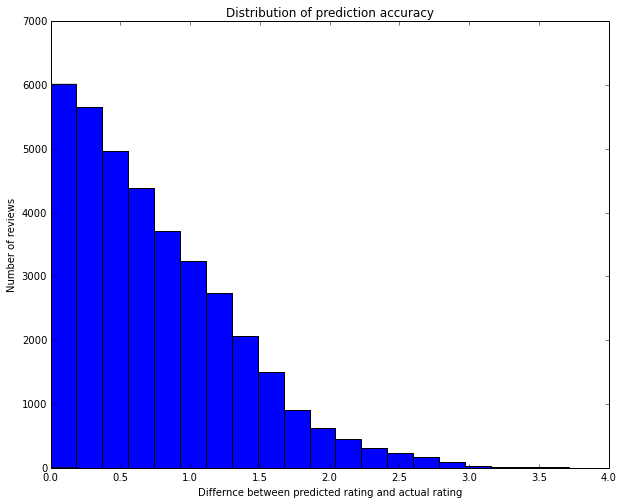

In [182]:
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(1,1,1)
n, bins, patches = ax.hist(diff_pred, bins=20)
ax.set_xlabel("Differnce between predicted rating and actual rating")
ax.set_ylabel("Number of reviews")
ax.set_title("Distribution of prediction accuracy")
print "Counts:", n
print "Bins:", bins
print "Percentage of points in the first five bins:", (n[0]+n[1]+n[2]+n[3]+n[4])/sum(n)

0.670021678538
0.585106382979
0.629402261712


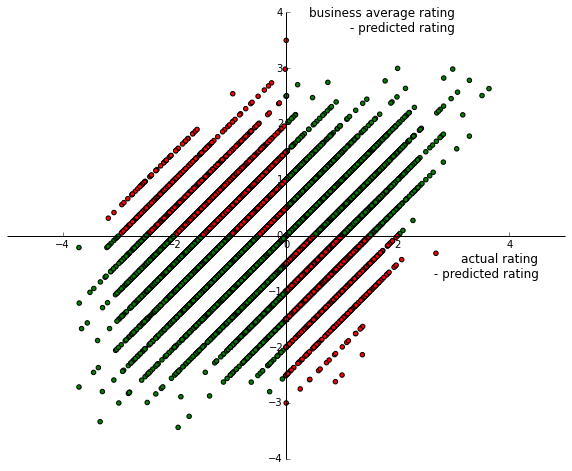

In [183]:
color=[]
count_qua=[0,0,0,0]
for i in range(len(actual_pred)):
    if ((actual_pred[i]*ba_pred[i])>0):
        color.append('g')
        if (actual_pred[i]>0):
            count_qua[0]+=1
        else:
            count_qua[2]+=1
    else:
        color.append('r')
        if (actual_pred[i]>0):
            count_qua[1]+=1
        else:
            count_qua[3]+=1

print float(count_qua[0])/(count_qua[0]+count_qua[3])
print float(count_qua[2])/(count_qua[1]+count_qua[2])
print float(count_qua[0]+count_qua[2])/sum(count_qua)

fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(1,1,1)
ax.scatter(actual_pred, ba_pred, c=color)
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.text(0.95, 0.40, 'actual rating\n - predicted rating',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        fontsize=12)

ax.text(0.80, 0.95, 'business average rating\n - predicted rating',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        fontsize=12)

In [184]:
np.corrcoef(actual_pred, ba_pred)

array([[ 1.        ,  0.34313976],
       [ 0.34313976,  1.        ]])

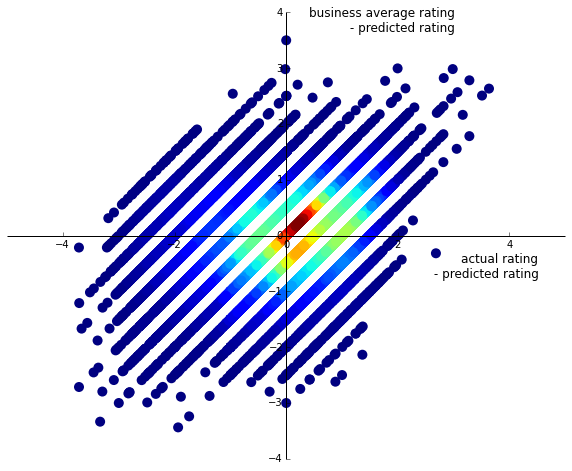

In [185]:
from scipy.stats import gaussian_kde
xy=np.vstack([actual_pred, ba_pred])
z=gaussian_kde(xy)(xy)

fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(1,1,1)
ax.scatter(actual_pred, ba_pred, c=z, s=100, edgecolor='')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.text(0.95, 0.40, 'actual rating\n - predicted rating',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        fontsize=12)

ax.text(0.80, 0.95, 'business average rating\n - predicted rating',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        fontsize=12)

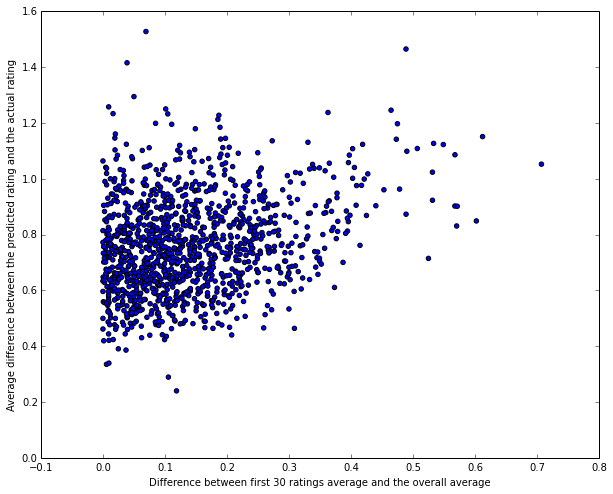

In [186]:
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(1,1,1)
ax.scatter(diff_n_stars, avg_diff)
ax.set_xlabel("Difference between first 30 ratings average and the overall average")
ax.set_ylabel("Average difference between the predicted rating and the actual rating")

In [187]:
np.corrcoef(diff_n_stars, avg_diff)

array([[ 1.       ,  0.2822672],
       [ 0.2822672,  1.       ]])

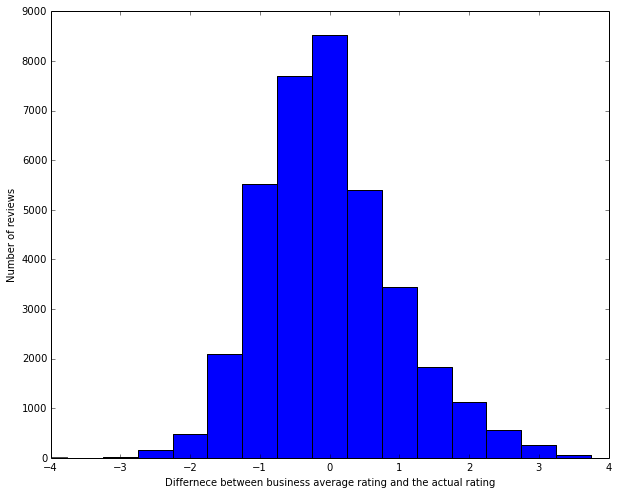

In [188]:
fig=plt.figure(figsize=(10,8))
bins1=[-4.25, -3.75, -3.25, -2.75, -2.25, -1.75, -1.25, -0.75, -0.25, 0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25]
ax=fig.add_subplot(1,1,1)
ba_act=[x-y for x, y in zip(ba_pred, actual_pred)]
n, bins, patches= ax.hist(ba_act, bins=bins1)
ax.set_xlabel("Differnece between business average rating and the actual rating")
ax.set_ylabel("Number of reviews")

In [189]:
print n
print bins
print (n[8]+n[7]+n[9])/sum(n)

[  0.00000000e+00   3.00000000e+00   1.90000000e+01   1.57000000e+02
   4.83000000e+02   2.09900000e+03   5.51200000e+03   7.69300000e+03
   8.51700000e+03   5.39300000e+03   3.43800000e+03   1.82800000e+03
   1.12100000e+03   5.59000000e+02   2.68000000e+02   5.00000000e+01
   0.00000000e+00]
[-4.25 -3.75 -3.25 -2.75 -2.25 -1.75 -1.25 -0.75 -0.25  0.25  0.75  1.25
  1.75  2.25  2.75  3.25  3.75  4.25]
0.581663974152
